# Nonlinear Least Squares curve fitting
Trying to put together a minimal implementation of the Levenberg-Marquardt algorithm for nonlinear least squares curve fitting.
This is mostly for my own learning, but it was also requested on [my blog](https://workyourtech.com/2020/04/05/fitting-curves-to-data-with-an-arduino/#comment-28)

## Following these papers: [this](http://people.duke.edu/~hpgavin/ce281/lm.pdf) and [this](https://www.eecs189.org/static/notes/n12.pdf)

# Nomenclature
 - x - x-values (probably time)
 - f(x) - function we're modelling the data as, this takes parameters p
 - y - f(x) data we're fitting the function to
 - p - parameters
 
- λ - LM factor that weights for either Gauss-Newton at high values, or Grad descent for low values

In [1]:
using Plots
using LinearAlgebra # For I

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `/mnt/hdd/docs/MATLAB/MatlabFiles/SolarArray/data/nonlinearcurvefitting/Project.toml`
  [91a5bcdd] + Plots v1.6.12
   Updating `/mnt/hdd/docs/MATLAB/MatlabFiles/SolarArray/data/nonlinearcurvefitting/Manifest.toml`
  [79e6a3ab] + Adapt v3.3.0
  [56f22d72] + Artifacts v1.3.0
  [6e34b625] + Bzip2_jll v1.0.6+5
  [35d6a980] + ColorSchemes v3.11.0
  [3da002f7] + ColorTypes v0.10.12
  [5ae59095] + Colors v0.12.7
  [34da2185] + Compat v3.27.0
  [d38c429a] + Contour v0.5.7
  [9a962f9c] + DataAPI v1.6.0
  [864edb3b] + DataStructures v0.18.9
  [e2d170a0] + DataValueInterfaces v1.0.0
  [5ae413db] + EarCut_jll v2.1.5+1
  [c87230d0] + FFMPEG v0.4.0
  [b22a6f82] + FFMPEG_jll v4.3.1+4
  [53c48c17] + FixedPointNumbers v0.8.4
  [59287772] + Formatting v0.4.2
  [d7e528f0] + FreeType2_jll v2.10.1+5
  [559328eb] + FriBidi_jll v1.0.5+6
  [28b8d3ca] + GR v0.52.0
  [5c1252a2] + GeometryBasics v0.3.12
  [4d00f742] + GeometryTypes v0.8.4
  [42e2da0e] + Grisu v1.0.0
  

## Chi square measure of goodness of fit (used for λ measure in LM algo)

In [2]:
function chisquare(O, E)
    return sum(((O .- E).^2) ./ E)
end

chisquare (generic function with 1 method)

## Parameter delta helper for Jacobian calculator (Forward differences)
The nicest way I've found to calculate the jacobian matrix is by generating a square matrix with each parameter perturbation in a row like this, then map each row of the perturbation matrix to get mxn matrix

In [92]:
function perturbparameters(parameters, perturbation)
    parametermatrix = hcat([copy(parameters) for i=1:length(parameters)]...)
    return parametermatrix + perturbation * I
end
perturbparameters([1, 2, 3], 0.0001)

3×3 Array{Float64,2}:
 1.0001  1.0     1.0
 2.0     2.0001  2.0
 3.0     3.0     3.0001

## Jacobian function
The functions we're working with here take a vector of datapoints of **m** length and return a vector of the function applied to each of those datapoints.

The function takes **n** parameters.

The jacobian is an **m**x**n** matrix that gives the gradient of each parameter if all the others are fixed, for all **n** datapoints.

In [110]:
function jacobian(f, x::Vector{Float64}, parameters, perturbation=1)::Array{Float64, 2}
    return cat(
        map(row -> (f(x, row...) - f(x, parameters...)) / perturbation,
            eachcol(perturbparameters(parameters, perturbation)))...,
        dims=2)
end

jacobian (generic function with 4 methods)

## Meat of the algo, two different update functions, gradient descent and gauss-newton

In [155]:
function gradient(y, ŷ, J, W=I)
    return transpose(J)*W*(y-ŷ)
end

function gaussnewton(y, ŷ, J, W=I)
    return inv(transpose(J)*W*J)*transpose(J)*W*(y-ŷ)
end

function lm(y, ŷ, J, λ, W=I)
    grad = transpose(J)*W*(y-ŷ)
    gaussnewton = transpose(J)*W*J + λ*Diagonal(transpose(J)*W*J)
    return  inv(gaussnewton) * grad
end

# symbol ρᵢ in first paper, this is compared to a user-given measure ϵ
function lmmetric(f, x, y, p, h, λ, J, W=I)
    yold = f(x, p...)
    ynew = f(x, (p .+ h)...)
    return (chisquare(y, yold) - chisquare(y, ynew)) /
        (transpose(h) * (λ * Diagonal(transpose(J)*W*J) * h + transpose(J)*W*(y-yold)))
end

# Todo: Use Broyden rank-1 update for updating jacobian in certain conditions
# http://people.duke.edu/~hpgavin/ce281/lm.pdf
# https://www.eecs189.org/static/notes/n12.pdf

function step(f, x::Vector{Float64}, y::Vector{Float64}, parameters;
        ϵ₁=1e-3, ϵ₂=1e-3, ϵ₄=1e-2, loss=(y, ŷ)->(sum((y-ŷ).^2)), maxiters=5000, lossvalues=[], ρvalues=[], λvalues=[])
    p = copy(parameters)
    
    λfactordown = 9
    λfactorup = 11
    λ = 1e-2
    
    iterations = 1
    # Initialise tso we can access it after while loop
    lossvalue = 2
    while true
        ŷ = f(x, p...)        
        
        J = jacobian(f, x, parameters)
        
        # Convergence criteria
        max(gradient(y, ŷ, J)...) < ϵ₁ || break
        chisquare(y, ŷ)/(length(y) - length(parameters) - 1) < ϵ₂ || break
        

        h = lm(y, ŷ, J, λ)
        ρ =lmmetric(f, x, y, parameters, h, λ, J)

        if ρ > ϵ₄
            p = p + h
            λ = max(λ / λfactordown, 10^-7)
        else
            λ = min(λ * λfactorup, 10^7)
        end
        
        lossvalue = loss(y, ŷ)
        push!(lossvalues, lossvalue)
        push!(ρvalues, ρ)
        push!(λvalues, λ)
        iterations = iterations + 1
        iterations > maxiters && break
    end
    print("Iterations: $(iterations), Loss: $(lossvalue)")
    return p
end

step (generic function with 1 method)

Define our function as one that takes a vector x and gives us back a vector y

In [156]:
f(x, a, b, c, d, e) = a.+b.*exp.(-c.*x) .* sin.(d.*x.+e)
x = collect(0:0.1:20)
actualparameters = [0.4, 0.6, 2, 0.75, 0.8]
y = f(x, actualparameters...)
p = [1.0, 1.0, 1.0, 1.0, 1.0]

lossvalues = Float64[]
ρvalues = Float64[]
λvalues = Float64[]

newparameters = step(f, collect(x), y, p, lossvalues=lossvalues, ρvalues=ρvalues, λvalues=λvalues)
ŷ = f(x, newparameters...);

Iterations: 1, Loss: 2

As we can see, the new parameters are close enough

In [154]:
print(newparameters)

[1.0, 1.0, 1.0, 1.0, 1.0]

vs

In [142]:
print(actualparameters)

[0.4, 0.6, 2.0, 0.75, 0.8]

Here we see the loss dropped significantly (Probably from the low lambda = gradient descent method)

But it pretty much flatlined as soon as it was low enough

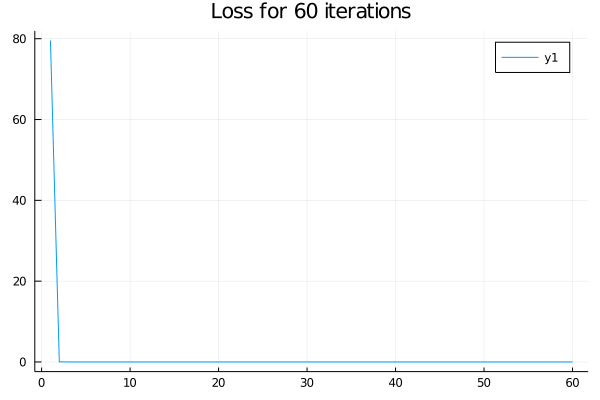

In [137]:
x_iter=1:length(lossvalues)
plot(x_iter, lossvalues, title="Loss for $(length(lossvalues)) iterations")

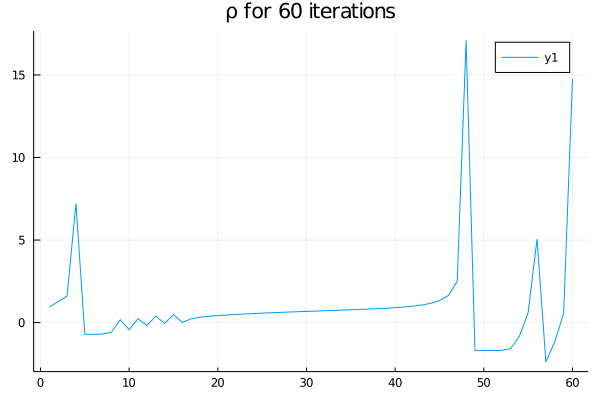

In [138]:
plot(x_iter, ρvalues, title="ρ for $(length(lossvalues)) iterations")

Interestingly, lambda did not change - we should be expecting it to move around

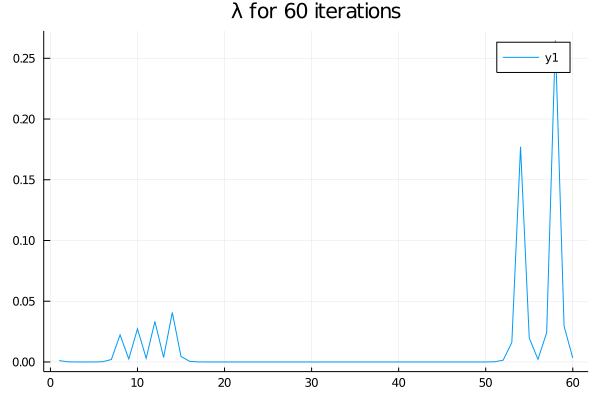

In [139]:
plot(x_iter, λvalues, title="λ for $(length(lossvalues)) iterations")

# Fitted parameters against the data, not great!

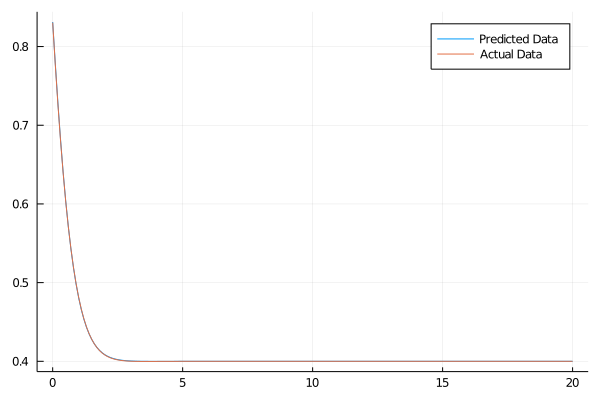

In [140]:
ŷ = f(x, newparameters...)
plot([x, x], [ŷ, y], label=["Predicted Data" "Actual Data"])

# Try a larger iteration to see if we can beat the loss

In [70]:
newparameters = step(f, collect(x), y, p, ϵ=1e-5, maxiters=99999, lossvalues=lossvalues, ρvalues=ρvalues, λvalues=λvalues)

Iterations: 100000, Loss: 0.025171947699427412

5-element Array{Float64,1}:
 0.40630008944965806
 0.4130416869947689
 1.1500785697535834
 0.9458429878071659
 1.1246721936555848

# Check function is "Type stable"

This macro expands into a list of the types Julia infers from the function, if they're all highlighted blue, then we're good!

In [67]:
@code_warntype step(f, collect(x), y, p)

Variables
  #self#::Core.Compiler.Const(step, false)
  f::Core.Compiler.Const(f, false)
  x::Array{Float64,1}
  y::Array{Float64,1}
  parameters::Array{Float64,1}
  #51::var"#51#53"

Body::Array{Float64,1}
1 ─      (#51 = %new(Main.:(var"#51#53")))
│   %2 = #51::Core.Compiler.Const(var"#51#53"(), false)
│   %3 = Base.vect()::Array{Any,1}
│   %4 = Base.vect()::Array{Any,1}
│   %5 = Base.vect()::Array{Any,1}
│   %6 = Main.:(var"#step#50")(0.01, %2, %3, %4, %5, #self#, f, x, y, parameters)::Array{Float64,1}
└──      return %6
